Epoch 1/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.6717 - loss: 0.5852 - val_accuracy: 0.8594 - val_loss: 0.3648 - learning_rate: 0.0010
Epoch 2/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.8775 - loss: 0.3091 - val_accuracy: 0.8250 - val_loss: 0.4085 - learning_rate: 0.0010
Epoch 3/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9177 - loss: 0.2177 - val_accuracy: 0.8598 - val_loss: 0.3581 - learning_rate: 5.0000e-04
Epoch 4/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 157s 999ms/step - accuracy: 0.9437 - loss: 0.1613 - val_accuracy: 0.8820 - val_loss: 0.3473 - learning_rate: 5.0000e-04
Epoch 5/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9607 - loss: 0.1273 - val_accuracy: 0.8742 - val_loss: 0.3480 - learning_rate: 5.0000e-04
Epoch 6/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 200s 1000ms/step - accuracy: 0.9715 - loss: 0.0964 - val_accuracy: 0.8722 - val_loss: 0.3669 - learning_rate: 2.5000e-04
Epoch 7/8
157/157 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0

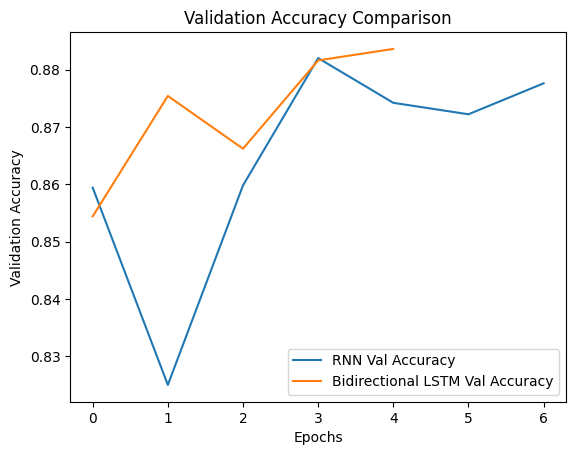

In [2]:
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

# Parameters
max_features = 10000
max_len = 500
batch_size = 128
embedding_dim = 100

# Load dataset
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

# Preprocess data
input_train = pad_sequences(input_train, maxlen=max_len)
input_test = pad_sequences(input_test, maxlen=max_len)

# Define early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)

# Define models
def build_fast_rnn_model():
    optimizer_rnn = Adam(learning_rate=0.001)  # Create a new optimizer instance for this model
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=max_len))
    model.add(LSTM(64, return_sequences=False))  # Reduced size for faster training
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer_rnn, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_fast_bi_lstm_model():
    optimizer_bilstm = Adam(learning_rate=0.001)  # Create a new optimizer instance for this model
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=max_len))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))  # Reduced size for speed
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer_bilstm, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train models
rnn_model = build_fast_rnn_model()
history_rnn = rnn_model.fit(
    input_train, y_train, epochs=8, batch_size=batch_size, validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

bi_lstm_model = build_fast_bi_lstm_model()
history_bi_lstm = bi_lstm_model.fit(
    input_train, y_train, epochs=8, batch_size=batch_size, validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate and plot
models = {
    "RNN": (rnn_model, history_rnn),
    "Bidirectional LSTM": (bi_lstm_model, history_bi_lstm)
}

for model_name, (model, history) in models.items():
    test_loss, test_acc = model.evaluate(input_test, y_test)
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")
    plt.plot(history.history['val_accuracy'], label=f"{model_name} Val Accuracy")

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()
